In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload


In [3]:
from mvl2 import genData2
from mvl2.numpyro import model, infer, run
from torch import tensor

In [4]:
r_p = tensor([[1., 0], [0, 1.]])
r_g = tensor([[1., .5], [.5, 1.]])
v_p = tensor([.05, .05])
h2 = tensor([.9, .9])

popgen_params = genData2.get_popgen_param(h2=h2, v_p=v_p, r_p=r_p, r_g=r_g)

# popgen_params["cov_p"] = popgen_params["r_p"]
# popgen_params["cov_e"] = popgen_params["r_e"]
# popgen_params["cov_g"] = popgen_params["r_g"]
sim_params = {
    "pi": tensor([.1, .1, .05]),
    **popgen_params,
    "RR_mean": tensor([3., 2.]),
    "PV_shape": tensor(1.),
    "PV_mean": tensor(1e-4),
    "PD": tensor([.01, .01]),
    # "PD_both": tensor(.005),
    "n_cases": tensor([1.5e4, 1.5e4, 4e3]),
    "n_ctrls": tensor(5e4),
    "fudge_factor": .1
}
sim_params

{'pi': tensor([0.1000, 0.1000, 0.0500]),
 'r_p': tensor([[1., 0.],
         [0., 1.]]),
 'r_g': tensor([[1.0000, 0.5000],
         [0.5000, 1.0000]]),
 'r_e': tensor([[ 1.0000, -0.0450],
         [-0.0450,  1.0000]]),
 'v_p': tensor([0.0500, 0.0500]),
 'v_g': tensor([0.0450, 0.0450]),
 'v_e': tensor([0.0050, 0.0050]),
 'cov_p': tensor([[0.0500, 0.0000],
         [0.0000, 0.0500]]),
 'cov_g': tensor([[0.0450, 0.0225],
         [0.0225, 0.0450]]),
 'cov_e': tensor([[ 0.0050, -0.0002],
         [-0.0002,  0.0050]]),
 'RR_mean': tensor([3., 2.]),
 'PV_shape': tensor(1.),
 'PV_mean': tensor(1.0000e-04),
 'PD': tensor([0.0100, 0.0100]),
 'n_cases': tensor([15000., 15000.,  4000.]),
 'n_ctrls': tensor(50000.),
 'fudge_factor': 0.1}

In [5]:
sim_data = genData2.gen_counts(**sim_params)

disease_z_scores tensor([-2.3263, -2.3263])
PD_with_both tensor([1.0000e-02, 1.0000e-02, 1.0000e-04], dtype=torch.float64)
mean_effects tensor([-0.4456, -0.2726])


In [6]:
sim_data["PVDs"].mean(0)

tensor([9.9235e-05, 1.3067e-04, 1.1518e-04, 1.5695e-04], dtype=torch.float64)

In [7]:
print(sim_data["PVDs"][sim_data["unaffected_genes"]].mean(0))
for i in range(len(sim_data["affected_genes"])):
    print(f"mean affects {i + 1}", sim_data["PVDs"][sim_data["affected_genes"][i]].mean(0))
    print(f"std affects {i + 1}", sim_data["PVDs"][sim_data["affected_genes"][i]].std(0))


tensor([9.9271e-05, 9.9271e-05, 9.9271e-05, 9.9271e-05], dtype=torch.float64)
mean affects 1 tensor([0.0001, 0.0001, 0.0002, 0.0002], dtype=torch.float64)
std affects 1 tensor([0.0001, 0.0001, 0.0002, 0.0002], dtype=torch.float64)
mean affects 2 tensor([9.6303e-05, 2.9935e-04, 2.0160e-04, 6.1397e-04], dtype=torch.float64)
std affects 2 tensor([9.5564e-05, 2.9874e-04, 2.0739e-04, 6.4852e-04], dtype=torch.float64)
mean affects 3 tensor([9.8864e-05, 3.0312e-04, 1.0095e-04, 3.0312e-04], dtype=torch.float64)
std affects 3 tensor([0.0001, 0.0003, 0.0001, 0.0003], dtype=torch.float64)


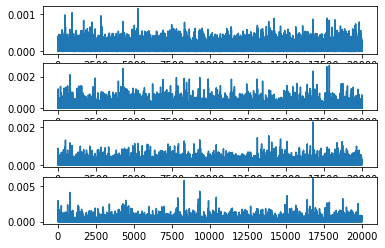

In [8]:
import matplotlib.pyplot as plt
fig, plts = plt.subplots(sim_data["PVDs"].shape[1])
print(plts)
for i in range(len(plts)):
    plts[i].plot(sim_data["PVDs"][:, i])

In [10]:
# With no prior on allele frequency
sim_params_point_pv = sim_params.copy()
sim_params_point_pv["PV_shape"] = None
sim_data_point_pv = genData2.gen_counts(**sim_params_point_pv)

disease_z_scores tensor([-2.3263, -2.3263])
PD_with_both tensor([1.0000e-02, 1.0000e-02, 1.0000e-04], dtype=torch.float64)
mean_effects tensor([-0.4456, -0.2726])


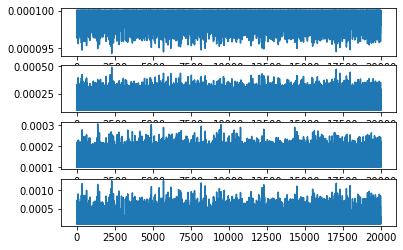

In [11]:
import matplotlib.pyplot as plt
fig, plts = plt.subplots(sim_data_point_pv["PVDs"].shape[1])
print(plts)
for i in range(len(plts)):
    plts[i].plot(sim_data_point_pv["PVDs"][:, i])

In [12]:
run_params = {
    "data": sim_data_point_pv["alt_counts"].numpy(),
    "n_cases": sim_params_point_pv["n_cases"].numpy(),
    "n_ctrls": sim_params_point_pv["n_ctrls"].numpy(),
    "max_tree_depth": 8,
    "num_warmup": 200,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 12,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}

mcmc, inferred_params = run(sim_data=sim_data_point_pv, run_params=run_params)

TypeError: JAX DeviceArray, like numpy.ndarray, is not hashable.